# House Price Regressor with TensorFlow

Загрузка набора данных Boston_Housing, включающего данные о ценах домов в пригороде бостона в 1970-х годах. Он содержит относительно немного образцов данных: всего 506, разбитых на 404 обучающих и 102 контрольных. И каждый признак во входных данных (например, уровень преступности) имеет свой масштаб. Например, некоторые признаки являются пропорциями и имеют значения между 0 и 1; другие — между 1 и 12, третьи — между 0 и 100 и т. д.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

(train_data, train_targets), (test_data, test_targets) = keras.datasets.boston_housing.load_data()

Нормализация данных путем вычитания среднего значения по данному признаку и деления полученной разности на стандартное отклонение.

In [10]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Построение модели. Поскольку нам потребуется несколько экземпляров одной и той же модели, мы определили функцию для ее создания. Из-за небольшого количества образцов мы возьмем очень маленькую сеть с двумя 64-мерными промежуточными слоями. Модель заканчивается одномерным слоем, не имеющим функции активации (это линейный слой). Это типичная конфигурация для скалярной регрессии (целью которой является предсказание одного значения на непрерывной числовой прямой).

In [11]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

Чтобы оценить качество модели в ходе корректировки ее параметров (таких, как количество эпох обучения), можно разбить исходные данные на обучающий и проверочный наборы. Однако, поскольку у нас имеется и без того небольшой набор данных, проверочный набор получился бы слишком маленьким (скажем, около 100 образцов). Как следствие, оценки при проверке могут сильно меняться в зависимости от того, какие данные попадут в проверочный и обучающий наборы: иными словами, могут иметь слишком большой разброс. Это не позволит надежно оценить качество модели. Лучшей практикой в таких ситуациях является применение перекрестной проверки по K блокам (K-fold cross-validation). Суть ее заключается в разделении доступных данных на K блоков (обычно K = 4 или 5), создании K идентичных моделей и обучении каждой на K – 1 блоках с оценкой по оставшимся блокам. По полученным K оценкам вычисляется среднее значение, которое принимается как оценка модели. В коде такая проверка реализуется достаточно просто.

In [12]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'Обработка блока {i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0
    )
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Обработка блока 0
Обработка блока 1
Обработка блока 2
Обработка блока 3


Создание истории последовательных средних оценок проверки по K блокам.

In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

 Формирование графика с оценками проверок.

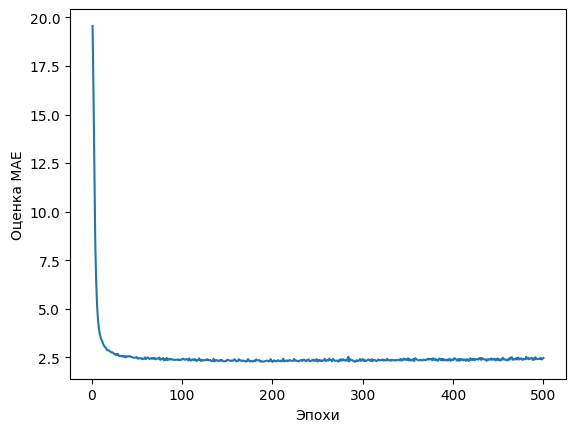

In [14]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Эпохи')
plt.ylabel('Оценка MAE')
plt.show()

Из-за проблем с масштабированием может быть немного затруднительно увидеть общую тенденцию: оценка MAE для первых нескольких эпох значительно выше, чем для последующих. Давайте опустим первые десять замеров с масштабом, отличным от масштаба остальной кривой.

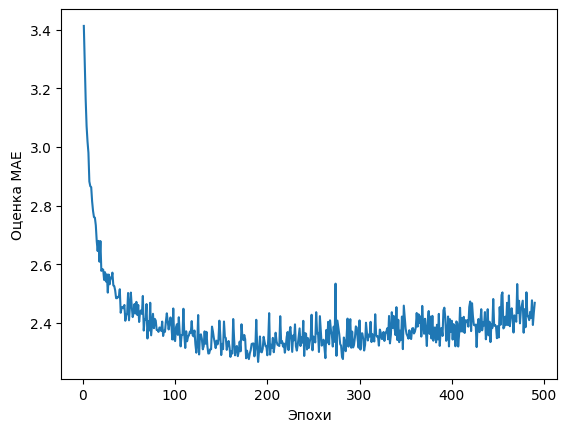

In [15]:
plt.clf()
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel('Эпохи')
plt.ylabel('Оценка MAE')
plt.show()

Обучение окончательной версии модели, учитывая переобучение после 120-140 эпох.

In [16]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.4239 - mae: 2.4500 


Проверка модели на тестовых данных.

In [17]:
predictions = model.predict(test_data)
print(predictions[0])  # Предсказание для первого дома

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[9.835871]
